In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import QuantumRegister, ClassicalRegister, Gate
from qiskit.quantum_info import hellinger_distance
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
from qiskit.transpiler import PassManager
from qiskit.providers.aer import AerSimulator
from itertools import combinations
from qiskit_ibm_provider import IBMProvider
import mapomatic as mm

In [2]:
# Implement the original circuit of QAOA for portfolio optimization
zahl_qubits = 7 # Number of qubits
# Coefficients of RZZ and RZ gates in the cost Hamiltonian of QAOA
wlist =  [[0, 6, 0.9675819891171697], [1, 5, 0.9575410360286538], [2, 4, 0.9746221745158998], [1, 6, 0.9974142468455173], [2, 5, 1.020758689912918], [3, 4, 1.0624879242203853], [1, 0, 0.9986121728652555], 
          [2, 6, 0.9778382416164966], [3, 5, 0.9694447491350203], [2, 0, 0.9474229925719706], [3, 6, 1.010016133635753], [4, 5, 0.9612340002654056], [2, 1, 0.9692769238689529], [3, 0, 0.9971729076948391], 
          [4, 6, 0.9998564951853779], [3, 1, 1.0383475665828785], [4, 0, 0.9959637377987142], [5, 6, 0.9662970761583268], [3, 2, 0.9808028770237761], [4, 1, 1.0240457232660027], [5, 0, 0.9381759698400806]]
ws =  [-0.42730498350153334, -2.153332801452803, -0.3371623610769825, -0.717961760224974, -1.0090206953768255, -0.6296038275915995, -1.177456927720805]
# Parameters gamma and beta in QAOA for depth ranging from 1 to 7 (optimized by classical optimizers)
thetas = [[0.15765675430497514, 0.2640581006183815],
          [ 0.15878744,  0.24727888,  2.56241436, -0.02910189],
          [ 0.16534242,  0.24955929,  3.81705593, -0.02898695,  0.99842058, -0.03018921],
          [ 0.16919031,  0.24547946,  3.720077  , -0.04361685,  0.66411631, 0.02364427,  0.97370823, -0.14019511], 
          [ 0.16956214,  0.24499457,  3.71920135, -0.04371177,  0.66476437, 0.02363428,  0.97364827, -0.14035714,  1.0001721 , -0.00765417], 
          [ 0.1720225 ,  0.27612842,  3.72702166, -0.04425292,  0.6659434 , 0.01751255,  0.97071991, -0.13907393,  1.99488397, -0.01279498, -0.00654631, -0.00620015], 
          [ 0.16248988,  0.2970913 ,  3.71832545, -0.05428204,  0.6523839 , 0.03380061,  0.95836542, -0.13577605,  1.73469262, -0.01747746, -0.00576932, -0.01910792,  1.14044675, -0.01891893]]

def construct_circuit(theta):
    global zahl_qubits, wlist, ws
    qc=QuantumCircuit(zahl_qubits,zahl_qubits)
    n= len(theta)
    for i in range(zahl_qubits):
        qc.h(i)
    j=0
    while j<n:
        for l in range(len(wlist)):
            qc.cx(wlist[l][0],wlist[l][1])
            qc.rz(2.0*theta[j]*wlist[l][2],wlist[l][1])
            qc.cx(wlist[l][0],wlist[l][1])
        for i in range(zahl_qubits):
            qc.rz(2.0*theta[j]*ws[i],i)
        j+=1
        for i in range(zahl_qubits):
            qc.rx(-2.0*theta[j],i)
        j+=1              
    qc.measure(range(zahl_qubits),range(zahl_qubits))
    return qc

In [3]:
# Implement AOQMAP for QAOA with fully connected two-qubit gates on linear topology
def rzzswap_gate(qc,q1,q2,gamma):
    qc.cx(q1,q2)
    qc.rz(2.0*gamma,q2)
    qc.cx(q2,q1)
    qc.cx(q1,q2)

def rzz_gate(qc,q1,q2,gamma):
    qc.cx(q1,q2)
    qc.rz(2.0*gamma,q2)
    qc.cx(q1,q2)

# Generate ZZ and ZZ-SWAP layers
def f_aoqmap_mapping_rzz(zahl_qubits: int):
    qc=QuantumCircuit(zahl_qubits)
    jj=0
    while jj<zahl_qubits:
        for q in range(0,zahl_qubits-1,2):
            if jj == 0 or jj==(zahl_qubits-1):
                gate_zz = Gate(name='rzz', num_qubits=2, params=[])
                qc.append(gate_zz, [q,q+1])
            else:
                gate_zzswap = Gate(name='zzswap', num_qubits=2, params=[])
                qc.append(gate_zzswap, [q,q+1])
        jj+=1
        if jj < zahl_qubits:
            for q in range(1,zahl_qubits-1,2):
                if jj == 0 or jj==(zahl_qubits-1):
                    gate_zz = Gate(name='rzz', num_qubits=2, params=[])
                    qc.append(gate_zz, [q,q+1])
                else:
                    gate_zzswap = Gate(name='zzswap', num_qubits=2, params=[])
                    qc.append(gate_zzswap, [q,q+1])
        jj+=1
    return qc

def get_qc_gate(qc):
    name_list=[]
    gate_list=[]
    for gate in qc.data:
        if gate[0].name != 'measure':
            if len(gate[0].params) == 0:
                name_list.append(gate[0].name)
            if len(gate[0].params) == 1:
                gate_name = '{}({})'.format(gate[0].name, (gate[0].params)[0])
                name_list.append(gate_name)
            if len(gate[1])==1:
                gate_list.append((gate[1][0].index, ))    
            if len(gate[1])==2:
                gate_index = [qc.find_bit(qarg)[0] for qarg in gate[1]]
                gate_list.append((gate_index[0], gate_index[1]))
        elif gate[0].name == 'measure':
            name_list.append('measure')
            gate_list.append((gate.qubits[0].index, gate.clbits[0].index))
    return [qc.num_qubits, tuple(gate_list), tuple(name_list)]

# AOQMAP-L: Construct the QAOA circuit after performing AOQMAP on a linear subtopology
def aoqmap_circ(theta, zahl_qubits):
    con = [[0]*zahl_qubits for _ in range(zahl_qubits)]
    for w in wlist:
        con[w[0]][w[1]] = w[-1]
        con[w[1]][w[0]] = w[-1]
    qord=list(range(zahl_qubits))
    qregs = QuantumRegister(zahl_qubits)
    cregs = ClassicalRegister(zahl_qubits)
    qc=QuantumCircuit(qregs,cregs)
    n= len(theta)
    for i in range(zahl_qubits):
        qc.h(qregs[i])  
    # Assign all ZZ and ZZ-SWAP gates
    qc_zz = f_aoqmap_mapping_rzz(zahl_qubits)
    all_gates = get_qc_gate(qc_zz)
    for i in range(0,n,2):
        j = 0
        for j in range(len(all_gates[-1])):
            c, t = all_gates[1][j]
            for k in range(len(wlist)):
                if (wlist[k][0]==c and wlist[k][1]==t) or (wlist[k][0]==t and wlist[k][1]==c):
                    if all_gates[-1][j] == 'rzz':
                        rzz_gate(qc, c, t, theta[i]*con[qord[c]][qord[t]])
                    elif all_gates[-1][j] in ['swap', 'SWAP']:
                        qc.swap(c, t)
                        qord[c],qord[t]=qord[t],qord[c] # SWAP gate exchanges the order of two qubits
                    elif all_gates[-1][j] == 'zzswap':
                        rzzswap_gate(qc, c, t, theta[i]*con[qord[c]][qord[t]])
                        qord[c],qord[t]=qord[t],qord[c]
        # Assign single qubit gates in the problem Hamiltonian
        for m in range(zahl_qubits):
            qc.rz(2.0*theta[i]*ws[qord[m]],m)
        # Assign single qubit gates in the mixer Hamiltonian
        for n in range(zahl_qubits):
            qc.rx(-2.0*theta[i+1],n)
    # Measure qubits according to the updated qubit order
    qc.measure(range(zahl_qubits), [qord[j] for j in range(zahl_qubits)])
    return qc

# AOQMAP-LS: AOQMAP for QAOA on linear topology leveraging the symmetry of SWAP layers
# QAOA with odd numbers of qubits: AOQMAP-LS generates the same circuit as AOQMAP-L
# QAOA with even numbers of qubits: AOQMAP-LS generates a different circuit than AOQMAP-L
def aoqmap_circ_symmetry(theta, zahl_qubits):
    p = int(len(theta)/2)
    n = len(theta)
    con = [[0]*zahl_qubits for _ in range(zahl_qubits)]
    for w in wlist:
        con[w[0]][w[1]] = w[-1]
        con[w[1]][w[0]] = w[-1]
    qord=list(range(zahl_qubits))
    qregs = QuantumRegister(zahl_qubits)
    cregs = ClassicalRegister(zahl_qubits)
    qc = QuantumCircuit(qregs, cregs)
    for i in range(zahl_qubits):
        qc.h(qregs[i])    
    pp = 0
    while pp<p:
        edges_sec = []
        edges_fir = []
        jj=0
        while jj<zahl_qubits:
            for q in range(0,zahl_qubits-1,2):
                if jj == 0 or jj==(zahl_qubits-1):
                    rzz_gate(qc,q, q+1, theta[2*pp]*con[qord[q]][qord[q+1]])
                else:
                    rzzswap_gate(qc,q, q+1, theta[2*pp]*con[qord[q]][qord[q+1]])
                    qord[q], qord[q+1] = qord[q+1], qord[q]
                if qord[q] < qord[q+1]:
                    edges_fir.append((qord[q], qord[q+1]))
                else:
                    edges_fir.append((qord[q+1], qord[q]))
            jj+=1
            if jj < zahl_qubits:
                for q in range(1,zahl_qubits-1,2):
                    if jj == 0 or jj==(zahl_qubits-1):
                        rzz_gate(qc,q,q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                    else:
                        rzzswap_gate(qc,q,q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                        qord[q], qord[q+1] = qord[q+1], qord[q]
                    if qord[q] < qord[q+1]:
                        edges_fir.append((qord[q], qord[q+1]))
                    else:
                        edges_fir.append((qord[q+1], qord[q]))
                jj+=1
        for m in range(zahl_qubits):
            qc.rz(2.0*theta[2*pp]*ws[qord[m]],m)
        for n in range(zahl_qubits):
            qc.rx(-2.0*theta[2*pp+1],n)
        pp += 1
        if pp<p:
            if (zahl_qubits-1) % 2 == 0:
                jj = 0
                while jj < zahl_qubits:
                    for q in range(0, zahl_qubits-1, 2):
                        if jj == 0 or jj == (zahl_qubits-1):
                            rzz_gate(qc,q,q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                        else:
                            rzzswap_gate(qc,q,q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                            qord[q], qord[q+1] = qord[q+1], qord[q]
                        if qord[q] < qord[q+1]:
                            edges_sec.append((qord[q], qord[q+1]))
                        else:
                            edges_sec.append((qord[q+1], qord[q]))
                    jj += 1
                    if jj < zahl_qubits:
                        for q in range(1, zahl_qubits-1, 2):
                            if jj == 0 or jj == (zahl_qubits-1):
                                rzz_gate(qc,q, q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                            else:
                                rzzswap_gate(qc,q, q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                                qord[q], qord[q+1] = qord[q+1], qord[q]
                            if qord[q] < qord[q+1]:
                                edges_sec.append((qord[q], qord[q+1]))
                            else:
                                edges_sec.append((qord[q+1], qord[q]))
                        jj += 1
            else:
                jj=0
                while jj<zahl_qubits:
                    for q in range(1,zahl_qubits-1,2):
                        if jj == 0 or jj==(zahl_qubits-1):
                            rzz_gate(qc,q,q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                        else:
                            rzzswap_gate(qc,q,q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                            qord[q], qord[q+1] = qord[q+1], qord[q]
                        if qord[q] < qord[q+1]:
                            edges_sec.append((qord[q], qord[q+1]))
                        else:
                            edges_sec.append((qord[q+1], qord[q]))       
                    jj+=1
                    if jj < zahl_qubits:
                        for q in range(0,zahl_qubits-1,2):
                            if jj == 0 or jj==(zahl_qubits-1):
                                rzz_gate(qc,q,q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                            else:
                                rzzswap_gate(qc,q, q+1,theta[2*pp]*con[qord[q]][qord[q+1]])
                                qord[q], qord[q+1] = qord[q+1], qord[q]
                            if qord[q] < qord[q+1]:
                                edges_sec.append((qord[q], qord[q+1]))
                            else:
                                edges_sec.append((qord[q+1], qord[q]))
                        jj+=1
            for m in range(zahl_qubits):
                qc.rz(2.0*theta[2*pp]*ws[qord[m]],m)
            for n in range(zahl_qubits):
                qc.rx(-2.0*theta[2*pp+1],n)
            pp += 1         
        qc.barrier()
    qc.measure([j for j in range(zahl_qubits)], [qord[j] for j in range(zahl_qubits)])
    return qc

gates:  OrderedDict([('cx', 84), ('rz', 56), ('rx', 14), ('h', 7), ('measure', 7)])
depth:  48


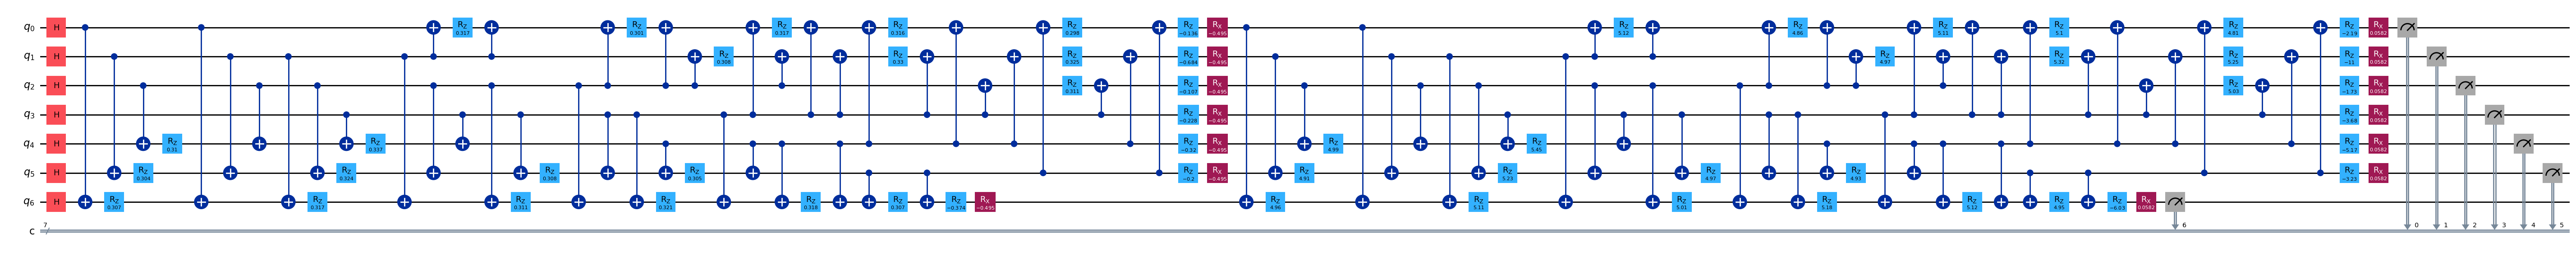

In [4]:
# Original QAOA circuit at depth 2
p=2
theta = thetas[p-1]
qc = construct_circuit(theta)
print('gates: ', qc.count_ops())
print('depth: ', qc.depth())
qc.draw('mpl', style="iqp", fold=-1)

gates:  OrderedDict([('cx', 114), ('rz', 56), ('rx', 14), ('h', 7), ('measure', 7)])
depth:  58


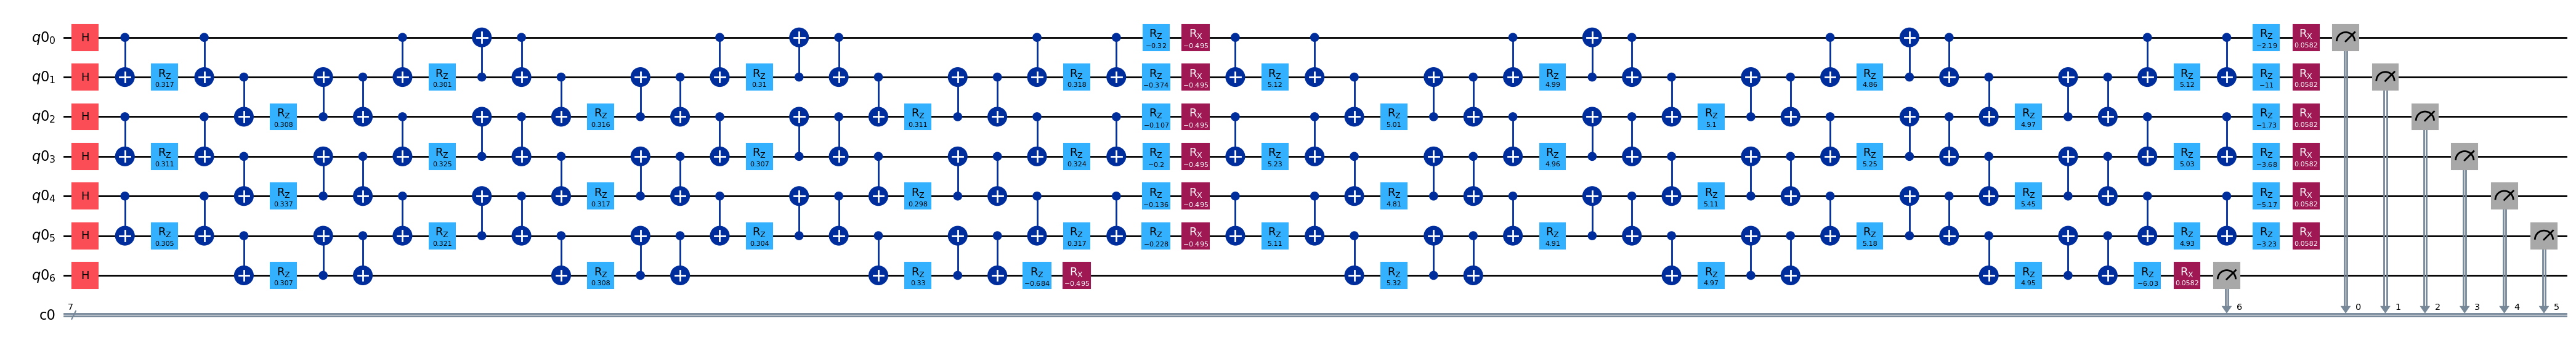

In [5]:
qc_aoqmap_l = aoqmap_circ(theta, zahl_qubits) # AOQMAP-L
print('gates: ', qc_aoqmap_l.count_ops())
print('depth: ', qc_aoqmap_l.depth())
qc_aoqmap_l.draw('mpl', style="iqp", fold=-1)

gates:  OrderedDict([('cx', 114), ('rz', 56), ('rx', 14), ('h', 7), ('measure', 7), ('barrier', 1)])
depth:  58


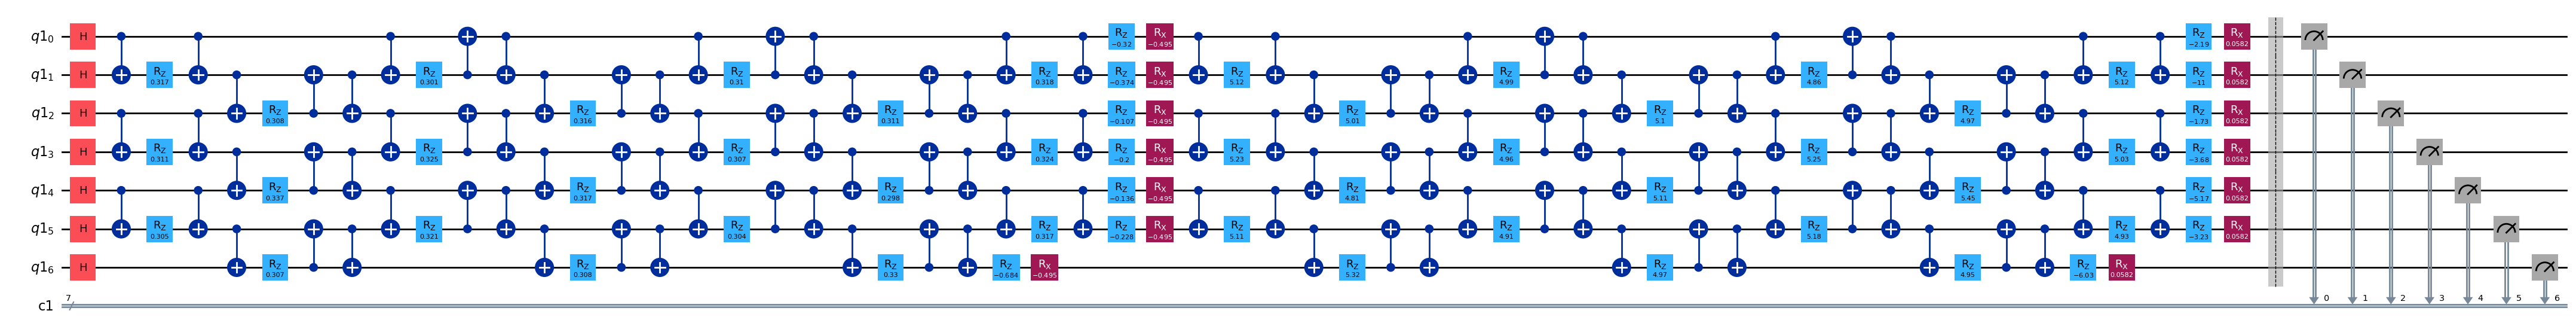

In [6]:
qc_aoqmap_ls = aoqmap_circ_symmetry(theta, zahl_qubits) # AOQMAP-LS
print('gates: ', qc_aoqmap_ls.count_ops())
print('depth: ', qc_aoqmap_ls.depth())
qc_aoqmap_ls.draw('mpl', style="iqp", fold=-1)

In [7]:
# Verification of mapped and original circuits by computing Hellinger distance
shots = 10000
sim_aer = AerSimulator()
job_orig = sim_aer.run(qc, shots=shots)
counts_orig = job_orig.result().get_counts()
job_aoqmap_l = sim_aer.run(qc_aoqmap_l, shots=shots)
counts_aoqmap_l = job_aoqmap_l.result().get_counts()
hell_dis_l = hellinger_distance(counts_orig, counts_aoqmap_l)
print('p = {}, AOQMAP-L, hellinger_distance = {}'.format(p, hell_dis_l))
job_aoqmap_ls = sim_aer.run(qc_aoqmap_ls, shots=shots)
counts_aoqmap_ls = job_aoqmap_ls.result().get_counts()
hell_dis_ls = hellinger_distance(counts_orig, counts_aoqmap_ls)
print('p = {}, AOQMAP-LS, hellinger_distance = {}'.format(p, hell_dis_ls))

p = 2, AOQMAP-L, hellinger_distance = 0.05164382637939792
p = 2, AOQMAP-LS, hellinger_distance = 0.0538967530346689


In [8]:
# Implement AOQMAP for QAOA with fully connected two-qubit gates on T-shaped topology
# The minimum number of T-shaped topology is 4
def f_edge_order(edge, order):
    return sorted([order[edge[0]], order[edge[1]]])

# Remove any possible SWAP gates located at the end of the circuit
def OptCircuit(qc):
    _meas = [OptimizeSwapBeforeMeasure()]
    pm = PassManager()
    pm.append(_meas)
    circ_opt = pm.run(qc)
    return circ_opt

def f_tshaped_extend(zahl_qubits):
    def generate_swap_layers(zahl_qubits):
        layers = []
        j = 0
        while j < zahl_qubits:
            lay = []
            lay.append([2,3])
            if zahl_qubits > 4:
                for k in range(4,zahl_qubits-1,2):
                    lay.append([k,k+1])
            layers.append(lay)
            j += 1
            if j < zahl_qubits:
                lay = []
                lay.append([0,2])
                if zahl_qubits > 4:
                    for k in range(3,zahl_qubits-1,2):
                        lay.append([k,k+1])
                layers.append(lay)
                j += 1
            if j < zahl_qubits:
                lay = []
                lay.append([2,3])
                if zahl_qubits > 4:
                    for k in range(4,zahl_qubits-1,2):
                        lay.append([k,k+1])
                layers.append(lay)
                j += 1
            if j < zahl_qubits:
                lay = []
                lay.append([1,2])
                if zahl_qubits > 4:
                    for k in range(3,zahl_qubits-1,2):
                        lay.append([k,k+1])
                layers.append(lay)
                j += 1
        return layers
    
    # Define the connectivity of a T-shaped subtopology
    def f_con_edges(zahl_qubits):
        con_edges = [[0,2],[1,2],[2,3]] + [[j,j+1] for j in range(3, zahl_qubits-1)]
        return con_edges
    
    gates_all = [sorted(f) for f in combinations(range(zahl_qubits), 2)]
    con_edges = f_con_edges(zahl_qubits)
    qord=list(range(zahl_qubits))
    layers = generate_swap_layers(zahl_qubits)
    qc = QuantumCircuit(zahl_qubits)
    gate_zz = Gate(name='rzz', num_qubits=2, params=[])
    for k in range(len(layers)):
        if len(gates_all) != 0:
            lay = layers[k]
            for gate in gates_all:
                if gate not in [f_edge_order(f, qord) for f in lay]:
                    if gate in [f_edge_order(f, qord) for f in con_edges]:
                        qc.append(gate_zz, [qord.index(gate[0]), qord.index(gate[1])])
                        gates_all.remove(sorted(gate))
            if len(gates_all) != 0:
                for gate in lay:
                    if sorted([qord[gate[0]], qord[gate[1]]]) in gates_all:
                        qc.append(gate_zz, gate)
                        gates_all.remove(sorted([qord[gate[0]], qord[gate[1]]]))
                        if len(gates_all) != 0:
                            qc.swap(gate[0],gate[1])
                            qord[gate[0]], qord[gate[1]] = qord[gate[1]], qord[gate[0]]
    qc = OptCircuit(qc)
    assert len(gates_all)==0
    return qc

# AOQMAP-T: Construct the QAOA circuit on a T-shaped subtopology
def aoqmap_circ_tshaped(theta, zahl_qubits):
    con = [[0]*zahl_qubits for _ in range(zahl_qubits)]
    for w in wlist:
        con[w[0]][w[1]] = w[-1]
        con[w[1]][w[0]] = w[-1]
    qord=list(range(zahl_qubits))
    qregs = QuantumRegister(zahl_qubits)
    cregs = ClassicalRegister(zahl_qubits)
    qc=QuantumCircuit(qregs,cregs)
    n= len(theta)
    for i in range(zahl_qubits):
        qc.h(qregs[i])
    qc_final = f_tshaped_extend(zahl_qubits)
    all_gates = get_qc_gate(qc_final)
    for i in range(0,n,2):
        j = 0
        for j in range(len(all_gates[-1])):
            c, t = all_gates[1][j]
            for k in range(len(wlist)):
                if (wlist[k][0]==c and wlist[k][1]==t) or (wlist[k][0]==t and wlist[k][1]==c):
                    if all_gates[-1][j] == 'rzz':
                        rzz_gate(qc, c, t, theta[i]*con[qord[c]][qord[t]])
                    elif all_gates[-1][j] in ['swap', 'SWAP']:
                        qc.swap(c, t)
                        qord[c],qord[t]=qord[t],qord[c]
                    elif all_gates[-1][j] == 'zzswap':
                        rzzswap_gate(qc, c, t, theta[i]*con[qord[c]][qord[t]])
                        qord[c],qord[t]=qord[t],qord[c]
        for m in range(zahl_qubits):
            qc.rz(2.0*theta[i]*ws[qord[m]],m)
        for n in range(zahl_qubits):
            qc.rx(-2.0*theta[i+1],n)
    qc.measure(range(zahl_qubits), [qord[j] for j in range(zahl_qubits)])
    tqc = transpile(qc, basis_gates=['h', 'cx', 'rz', 'rx'])
    return tqc

gates:  OrderedDict([('cx', 108), ('rz', 56), ('rx', 14), ('h', 7), ('measure', 7)])
depth:  82


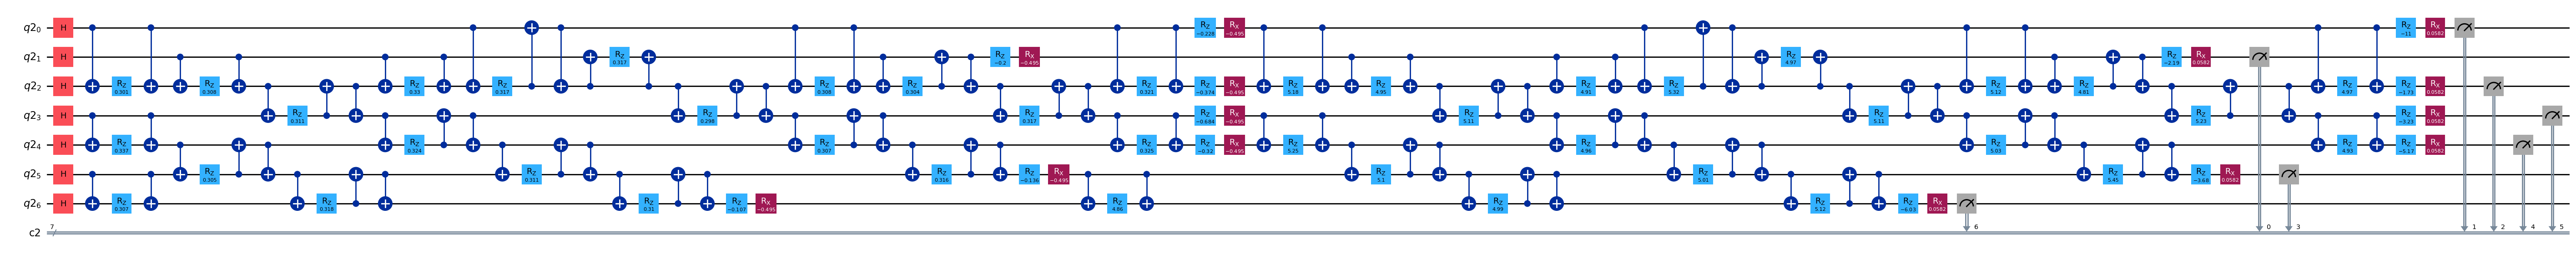

In [9]:
qc_aoqmap_t = aoqmap_circ_tshaped(theta, zahl_qubits) # AOQMAP-T
print('gates: ', qc_aoqmap_t.count_ops())
print('depth: ', qc_aoqmap_t.depth())
qc_aoqmap_t.draw('mpl', style="iqp", fold=-1)

In [10]:
job_aoqmap_t = sim_aer.run(qc_aoqmap_t, shots=shots)
counts_aoqmap_t = job_aoqmap_t.result().get_counts()
hell_dis_t = hellinger_distance(counts_orig, counts_aoqmap_t)
print('p = {}, AOQMAP-T, hellinger_distance = {}'.format(p, hell_dis_t))

p = 2, AOQMAP-T, hellinger_distance = 0.05708971703063204


In [11]:
# Implement AOQMAP for QAOA with fully connected two-qubit gates on a H-shaped topology
# The qubit numbers for a H-shaped topology are 7, 9, 11, ...
def f_hshaped_extend(zahl_qubits):
    def generate_swap_layers(zahl_qubits, target_n_layers):
        if zahl_qubits%2 !=0:
            layers = []
            j = 0
            while j < target_n_layers:
                if j < target_n_layers:
                    lay = []
                    lay.append([0,2])
                    if zahl_qubits > 6:
                        for k in range(3,zahl_qubits-2,2):
                            lay.append([k,k+1])
                    layers.append(lay)
                    j += 1
                if j < target_n_layers:
                    lay = []
                    lay.append([2,3])
                    if zahl_qubits > 6:
                        for k in range(4,zahl_qubits-2,2):
                            lay.append([k,k+1])
                    layers.append(lay)
                    j += 1
                if j < target_n_layers:
                    lay = []
                    lay.append([1,2])
                    if zahl_qubits > 6:
                        for k in range(3,zahl_qubits-2,2):
                            lay.append([k,k+1])
                    layers.append(lay)
                    j += 1
                if j < target_n_layers:
                    lay = []
                    lay.append([2,3])
                    if zahl_qubits > 8:
                        for k in range(4,zahl_qubits-3,2):
                            lay.append([k,k+1])
                    lay.append([zahl_qubits-3,zahl_qubits-1])
                    layers.append(lay)

                    j += 1
        else:
            layers = []
            j = 0
            while j < target_n_layers:
                if j < target_n_layers:
                    lay = []
                    lay.append([2,3])
                    if zahl_qubits > 7:
                        for k in range(4,zahl_qubits-2,2):
                            lay.append([k,k+1])
                    layers.append(lay)
                    j += 1
                if j < target_n_layers:
                    lay = []
                    lay.append([1,2])
                    if zahl_qubits > 5:
                        for k in range(3,zahl_qubits-2,2):
                            lay.append([k,k+1])
                    layers.append(lay)
                    j += 1
                if j < target_n_layers:
                    lay = []
                    lay.append([2,3])
                    if zahl_qubits > 7:
                        for k in range(4,zahl_qubits-2,2):
                            lay.append([k,k+1])
                    layers.append(lay)
                    j += 1
                if j < target_n_layers:
                    lay = []
                    lay.append([0,2])
                    if zahl_qubits > 6:
                        for k in range(3,zahl_qubits-3,2):
                            lay.append([k,k+1])
                    lay.append([zahl_qubits-3,zahl_qubits-1])
                    layers.append(lay)
                    j += 1
        return layers

    # Define the connectivity of a H-shaped topology
    def f_con_edges(zahl_qubits:int):
        con_edges = [[0,2],[1,2],[2,3]] + [[j,j+1] for j in range(3, zahl_qubits-2)] + [[zahl_qubits-3, zahl_qubits-1]]
        return con_edges

    gates_all = [sorted(f) for f in combinations(range(zahl_qubits), 2)]
    con_edges = f_con_edges(zahl_qubits)
    qord=list(range(zahl_qubits))
    layers = generate_swap_layers(zahl_qubits, zahl_qubits)
    qc = QuantumCircuit(zahl_qubits)
    gate_zz = Gate(name='rzz', num_qubits=2, params=[])
    for k in range(len(layers)):
        if len(gates_all) != 0:
            lay = layers[k]
            for gate in gates_all:
                if gate not in [f_edge_order(f, qord) for f in lay]:
                    if gate in [f_edge_order(f, qord) for f in con_edges]:
                        qc.append(gate_zz, [qord.index(gate[0]), qord.index(gate[1])])
                        gates_all.remove(sorted(gate))
            if len(gates_all) != 0:
                for gate in lay:
                    if sorted([qord[gate[0]], qord[gate[1]]]) in gates_all:
                        qc.append(gate_zz, gate)
                        gates_all.remove(sorted([qord[gate[0]], qord[gate[1]]]))
                        if len(gates_all) != 0:
                            qc.swap(gate[0],gate[1])
                            qord[gate[0]], qord[gate[1]] = qord[gate[1]], qord[gate[0]]
    qc = OptCircuit(qc)
    assert len(gates_all)==0
    return qc

# AOQMAP-H: Construct the QAOA circuit on a H-shaped topology
def aoqmap_circ_hshaped(theta, zahl_qubits):
    con = [[0]*zahl_qubits for _ in range(zahl_qubits)]
    for w in wlist:
        con[w[0]][w[1]] = w[-1]
        con[w[1]][w[0]] = w[-1]
    qord=list(range(zahl_qubits))
    qregs = QuantumRegister(zahl_qubits)
    cregs = ClassicalRegister(zahl_qubits)
    qc=QuantumCircuit(qregs,cregs)
    n= len(theta)
    for i in range(zahl_qubits):
        qc.h(qregs[i])
    qc_final = f_hshaped_extend(zahl_qubits)
    all_gates = get_qc_gate(qc_final)
    for i in range(0,n,2):
        j = 0
        for j in range(len(all_gates[-1])):
            c, t = all_gates[1][j]
            for k in range(len(wlist)):
                if (wlist[k][0]==c and wlist[k][1]==t) or (wlist[k][0]==t and wlist[k][1]==c):
                    if all_gates[-1][j] == 'rzz':
                        rzz_gate(qc, c, t, theta[i]*con[qord[c]][qord[t]])
                    elif all_gates[-1][j] in ['swap', 'SWAP']:
                        qc.swap(c, t)
                        qord[c],qord[t]=qord[t],qord[c]
                    elif all_gates[-1][j] == 'zzswap':
                        rzzswap_gate(qc, c, t, theta[i]*con[qord[c]][qord[t]])
                        qord[c],qord[t]=qord[t],qord[c]
        for m in range(zahl_qubits):
            qc.rz(2.0*theta[i]*ws[qord[m]],m)
        for n in range(zahl_qubits):
            qc.rx(-2.0*theta[i+1],n)
    qc.measure(range(zahl_qubits), [qord[j] for j in range(zahl_qubits)])
    tqc = transpile(qc, basis_gates=['h', 'cx', 'rz', 'rx'])
    return tqc

gates:  OrderedDict([('cx', 106), ('rz', 56), ('rx', 14), ('h', 7), ('measure', 7)])
depth:  90


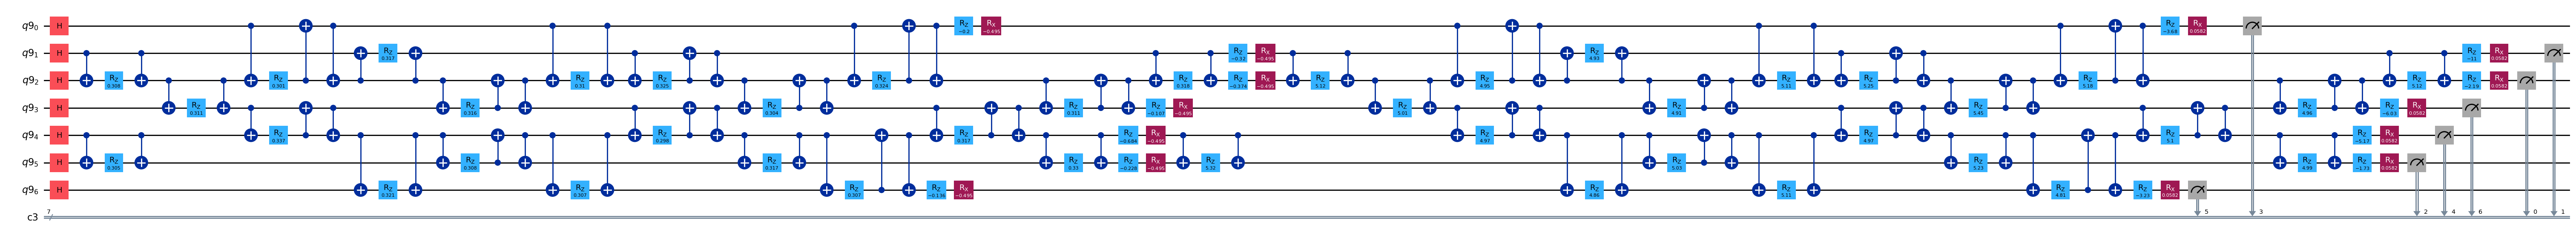

In [12]:
qc_aoqmap_h = aoqmap_circ_hshaped(theta, zahl_qubits) # AOQMAP-H
print('gates: ', qc_aoqmap_h.count_ops())
print('depth: ', qc_aoqmap_h.depth())
qc_aoqmap_h.draw('mpl', style="iqp", fold=-1)

In [13]:
job_aoqmap_h = sim_aer.run(qc_aoqmap_h, shots=shots)
counts_aoqmap_h = job_aoqmap_h.result().get_counts()
hell_dis_h = hellinger_distance(counts_orig, counts_aoqmap_h)
print('p = {}, AOQMAP-H, hellinger_distance = {}'.format(p, hell_dis_h))

p = 2, AOQMAP-H, hellinger_distance = 0.05351464021224311


In [14]:
# Qubit selection process for AOQMAP-LS
IBMProvider.save_account(token="d41e8e7776fc2c269962504216105958aad1b35fcecb49bfe5148ccfc5df376b33efcd2663fe60d43427b1f3d946a7bb4b1fdca6a839238b0287698942ccb762", overwrite=True)
provider = IBMProvider(instance="ibm-q/open/main")
backend = provider.get_backend('ibm_brisbane')
# backend.status()

In [15]:
config = backend.configuration()
basis_gates = config.basis_gates

tqc_ls_dec = transpile(qc_aoqmap_ls, basis_gates=basis_gates)
tqc_ls_backend = transpile(qc_aoqmap_ls, backend=backend)
assert tqc_ls_backend.count_ops()['ecr'] <= tqc_ls_dec.count_ops()['ecr'] # The mapping process should not increase the two-qubit gates

In [16]:
# Use mapomatic to find the best layout
def_tqc_ls = mm.deflate_circuit(tqc_ls_backend)
layouts_ls = mm.matching_layouts(def_tqc_ls, backend)
scores = mm.evaluate_layouts(tqc_ls_backend, layouts_ls, backend)

gates:  OrderedDict([('rz', 326), ('sx', 228), ('ecr', 114), ('x', 29), ('measure', 7), ('barrier', 1)])
depth:  147


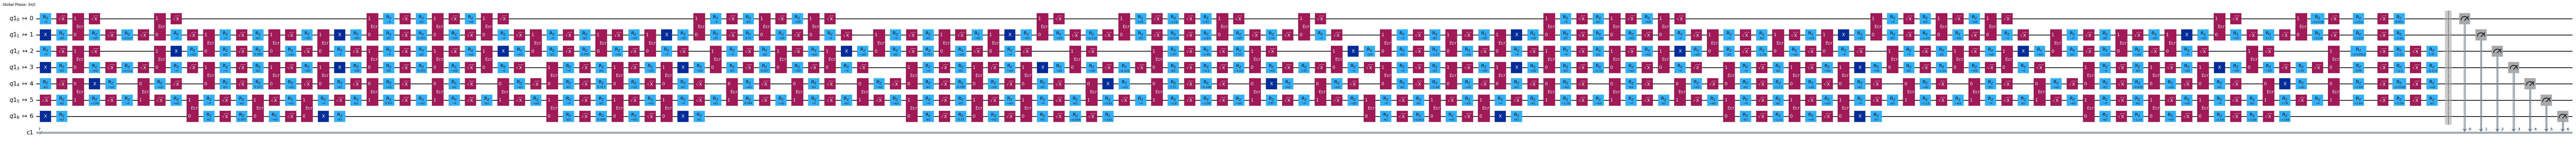

In [17]:
best_tqc_ls = transpile(tqc_ls_dec, backend, initial_layout=scores[0][0])
assert best_tqc_ls.count_ops()['ecr'] <= tqc_ls_dec.count_ops()['ecr'] # The mapping process should not increase the two-qubit gates
print('gates: ', best_tqc_ls.count_ops())
print('depth: ', best_tqc_ls.depth())
best_tqc_ls.draw('mpl', style="iqp", fold=-1, idle_wires=False)

In [18]:
# Run on quantum device
job_list_bk = backend.run(best_tqc_ls,shots=shots)
print('job_id is %s' % job_list_bk.job_id())
counts_list_bk = job_list_bk.result().get_counts()
print('counts = ',counts_list_bk)

job_id is cwta1dd997wg008xq6e0
counts =  {'0010111': 179, '0010100': 97, '0101110': 86, '1011011': 77, '0010101': 138, '0011110': 177, '0010011': 26, '1011010': 50, '1010010': 47, '1101011': 33, '0110111': 53, '0000100': 54, '0011011': 68, '0101100': 77, '1110011': 34, '0110101': 137, '1010100': 92, '1100011': 61, '0010110': 66, '1101111': 27, '1010000': 39, '1100000': 49, '0111101': 101, '1011100': 134, '0101111': 40, '0111011': 19, '1110101': 24, '1001011': 73, '0011010': 57, '0010001': 47, '0100001': 45, '0011101': 243, '0001111': 82, '0111110': 128, '1000011': 80, '0100000': 35, '1111101': 35, '0001010': 40, '0111100': 188, '1111011': 25, '1100111': 41, '0101101': 56, '1000110': 125, '0100110': 47, '1011101': 72, '0111000': 70, '1011110': 124, '0011111': 120, '0101011': 41, '1101001': 48, '0111111': 46, '1001100': 229, '1001001': 48, '0100010': 34, '0110100': 128, '1001110': 103, '1000111': 244, '1111000': 157, '0010010': 16, '1110111': 42, '0001011': 82, '0111001': 53, '1111100': 